In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.utils.tensorboard as tb
from Preprocessing.preprocessing import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd

In [16]:
#static parameters
train_batch_size = 170
val_batch_size = 170
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 38
clip = 3

In [17]:
#get data from preprocessing.py
dataset_path = os.path.join(os.path.abspath('..'),'Dataset\\Clementi dataset\\Clementi dataset' )
network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
network_input, network_output = network_input.cuda(), network_output.cuda()

# print(network_input)
#print(network_output)

In [18]:
print(network_output.max())
print(network_output.min())

tensor(37, device='cuda:0')
tensor(0, device='cuda:0')


In [19]:
#network_output

In [20]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
89
50
{0: 50, 1: 52, 2: 53, 3: 54, 4: 55, 5: 56, 6: 57, 7: 58, 8: 59, 9: 60, 10: 61, 11: 62, 12: 63, 13: 64, 14: 65, 15: 66, 16: 67, 17: 68, 18: 69, 19: 70, 20: 71, 21: 72, 22: 73, 23: 74, 24: 75, 25: 76, 26: 77, 27: 78, 28: 79, 29: 80, 30: 81, 31: 82, 32: 83, 33: 84, 34: 85, 35: 86, 36: 88, 37: 89}


In [21]:
'''
data is highly unbalanced
# '''
# sns.distplot(torch.tensor(network_output).cpu())
# xx = pd.DataFrame(torch.tensor(network_output).cpu())
# xx.groupby(0).size().to_frame(name='values')

'\ndata is highly unbalanced\n# '

In [22]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -117]
network_output = network_output[: -117]

print(network_input.shape)
print(network_output.shape)

torch.Size([8500, 50, 1])
torch.Size([8500])


In [23]:
#network_input[0]

In [24]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm1 = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = hidden_size, hidden_size = output_size,batch_first = True)
        
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(output_size, output_size)
        
        
    def forward(self, x, hidden1, hidden2,batch_size):
        
        output, _ = self.lstm1(x)        
        #print(output.shape)
        
        #output = self.dropout(output)
        
        output, _ = self.lstm2(output)
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, 38)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output, hidden2
    
    def hidden_init(self,batch_size):
        
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden1 = (weight.new(1, batch_size, self.hidden_size).zero_().cuda(),
          weight.new(1, batch_size, self.hidden_size).zero_().cuda())
        
        hidden2 = (weight.new(1, batch_size, 38).zero_().cuda(),
          weight.new(1, batch_size, 38).zero_().cuda())
        return hidden1,hidden2

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

    

In [25]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [26]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [27]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [28]:
#hidden = model.hidden_init(train_batch_size) 
#hidden

In [29]:
epochs = 500
min_val_loss = np.Inf

for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    
    hidden1, hidden2 = model.hidden_init(train_batch_size)    
    #print('hidden[0].shape:- ',hidden[0].shape)
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        '''
        Creating new variables for the hidden state, otherwise
        we'd backprop through the entire training history
        '''
        #h = tuple([each.data for each in hidden])
        
        h1 = tuple([each.data for each in hidden1])
        h2 = tuple([each.data for each in hidden2])
        
        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output, _ = model.forward(inputs, h1, h2, train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        val_h1 = tuple([each.data for each in hidden1])
        val_h2 = tuple([each.data for each in hidden2])
        
        output, _ = model.forward(inputs, val_h1, val_h2,val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256-38-removed_Ht_Ct.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 3.3479235 	Val Loss:3.0259093 	Train Acc: 8.514706% 	Val Acc: 11.4117651%
Validation Loss decreased from    inf to 3.025909, saving the model weights
Epoch: 1	Train Loss: 3.1590553 	Val Loss:2.9777230 	Train Acc: 8.617647% 	Val Acc: 11.4117651%
Validation Loss decreased from 3.025909 to 2.977723, saving the model weights
Epoch: 2	Train Loss: 3.1271409 	Val Loss:2.9652464 	Train Acc: 9.014706% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.977723 to 2.965246, saving the model weights
Epoch: 3	Train Loss: 3.1119785 	Val Loss:2.9602911 	Train Acc: 8.602941% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.965246 to 2.960291, saving the model weights
Epoch: 4	Train Loss: 3.1020215 	Val Loss:2.9553184 	Train Acc: 8.882353% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.960291 to 2.955318, saving the model weights
Epoch: 5	Train Loss: 3.0890726 	Val Loss:2.9467849 	Train Acc: 9.014706% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.955318 to

Epoch: 56	Train Loss: 2.3844979 	Val Loss:2.3331686 	Train Acc: 20.23529% 	Val Acc: 20.2352946%
Epoch: 57	Train Loss: 2.3737416 	Val Loss:2.3185664 	Train Acc: 20.61765% 	Val Acc: 21.8235298%
Validation Loss decreased from 2.327679 to 2.318566, saving the model weights
Epoch: 58	Train Loss: 2.3621731 	Val Loss:2.3364659 	Train Acc: 21.36765% 	Val Acc: 21.1764710%
Epoch: 59	Train Loss: 2.3706397 	Val Loss:2.3167745 	Train Acc: 20.88235% 	Val Acc: 21.6470592%
Validation Loss decreased from 2.318566 to 2.316775, saving the model weights
Epoch: 60	Train Loss: 2.3524439 	Val Loss:2.3072916 	Train Acc: 21.72059% 	Val Acc: 21.3529414%
Validation Loss decreased from 2.316775 to 2.307292, saving the model weights
Epoch: 61	Train Loss: 2.3396824 	Val Loss:2.2948423 	Train Acc: 21.88235% 	Val Acc: 22.8235297%
Validation Loss decreased from 2.307292 to 2.294842, saving the model weights
Epoch: 62	Train Loss: 2.3295479 	Val Loss:2.2802748 	Train Acc: 22.5% 	Val Acc: 25.1176478%
Validation Loss decr

Epoch: 120	Train Loss: 1.9771446 	Val Loss:2.0567003 	Train Acc: 34.61765% 	Val Acc: 31.8823539%
Epoch: 121	Train Loss: 1.9675423 	Val Loss:2.0594134 	Train Acc: 35.94118% 	Val Acc: 31.5882362%
Epoch: 122	Train Loss: 1.9996448 	Val Loss:2.0373172 	Train Acc: 34.60294% 	Val Acc: 33.0000010%
Epoch: 123	Train Loss: 1.9988202 	Val Loss:2.0386911 	Train Acc: 34.60294% 	Val Acc: 32.4705891%
Epoch: 124	Train Loss: 2.0203782 	Val Loss:2.0451034 	Train Acc: 33.77941% 	Val Acc: 32.1176481%
Epoch: 125	Train Loss: 2.0059780 	Val Loss:2.1394418 	Train Acc: 34.42647% 	Val Acc: 29.7647066%
Epoch: 126	Train Loss: 2.0516317 	Val Loss:2.0179561 	Train Acc: 33.60294% 	Val Acc: 35.0588244%
Epoch: 127	Train Loss: 2.0269356 	Val Loss:1.9187212 	Train Acc: 33.75% 	Val Acc: 38.1176478%
Validation Loss decreased from 1.982960 to 1.918721, saving the model weights
Epoch: 128	Train Loss: 2.0088487 	Val Loss:1.9355093 	Train Acc: 34.44118% 	Val Acc: 37.6470596%
Epoch: 129	Train Loss: 1.9918451 	Val Loss:1.9164649

Epoch: 184	Train Loss: 1.1526139 	Val Loss:1.0428177 	Train Acc: 63.79412% 	Val Acc: 70.3529418%
Validation Loss decreased from 1.055442 to 1.042818, saving the model weights
Epoch: 185	Train Loss: 1.1500479 	Val Loss:1.0034060 	Train Acc: 64.48529% 	Val Acc: 68.9999998%
Validation Loss decreased from 1.042818 to 1.003406, saving the model weights
Epoch: 186	Train Loss: 1.1605620 	Val Loss:0.9731079 	Train Acc: 63.75% 	Val Acc: 71.9999999%
Validation Loss decreased from 1.003406 to 0.973108, saving the model weights
Epoch: 187	Train Loss: 1.1285251 	Val Loss:0.9957729 	Train Acc: 65.0% 	Val Acc: 70.7058823%
Epoch: 188	Train Loss: 1.1266726 	Val Loss:1.0095059 	Train Acc: 64.57353% 	Val Acc: 70.6470585%
Epoch: 189	Train Loss: 1.1541574 	Val Loss:0.9908749 	Train Acc: 63.85294% 	Val Acc: 72.1764708%
Epoch: 190	Train Loss: 1.1243684 	Val Loss:0.9373568 	Train Acc: 64.23529% 	Val Acc: 72.5294119%
Validation Loss decreased from 0.973108 to 0.937357, saving the model weights
Epoch: 191	Train

Epoch: 248	Train Loss: 0.4725954 	Val Loss:0.2737461 	Train Acc: 85.94118% 	Val Acc: 93.8823521%
Epoch: 249	Train Loss: 0.4660373 	Val Loss:0.2745495 	Train Acc: 86.14706% 	Val Acc: 93.6470574%
Epoch: 250	Train Loss: 0.4645251 	Val Loss:0.3275952 	Train Acc: 85.98529% 	Val Acc: 91.0588217%
Epoch: 251	Train Loss: 0.4793014 	Val Loss:0.3410774 	Train Acc: 85.92647% 	Val Acc: 91.1176455%
Epoch: 252	Train Loss: 0.4808467 	Val Loss:0.2791814 	Train Acc: 85.48529% 	Val Acc: 93.0588222%
Epoch: 253	Train Loss: 0.4707140 	Val Loss:0.2471502 	Train Acc: 85.52941% 	Val Acc: 94.7058821%
Epoch: 254	Train Loss: 0.4407174 	Val Loss:0.2275843 	Train Acc: 87.10294% 	Val Acc: 95.5882335%
Epoch: 255	Train Loss: 0.4192215 	Val Loss:0.1943141 	Train Acc: 87.44118% 	Val Acc: 96.1176461%
Validation Loss decreased from 0.226050 to 0.194314, saving the model weights
Epoch: 256	Train Loss: 0.3825817 	Val Loss:0.1647053 	Train Acc: 88.70588% 	Val Acc: 97.2352928%
Validation Loss decreased from 0.194314 to 0.1647

Epoch: 319	Train Loss: 0.1629860 	Val Loss:0.0533994 	Train Acc: 95.77941% 	Val Acc: 99.0588224%
Epoch: 320	Train Loss: 0.1576117 	Val Loss:0.0450137 	Train Acc: 95.94118% 	Val Acc: 99.1176462%
Validation Loss decreased from 0.049301 to 0.045014, saving the model weights
Epoch: 321	Train Loss: 0.1462356 	Val Loss:0.0550387 	Train Acc: 96.39706% 	Val Acc: 98.8823515%
Epoch: 322	Train Loss: 0.1413833 	Val Loss:0.0474521 	Train Acc: 96.14706% 	Val Acc: 98.7647045%
Epoch: 323	Train Loss: 0.1458784 	Val Loss:0.0458538 	Train Acc: 96.23529% 	Val Acc: 99.1764700%
Epoch: 324	Train Loss: 0.1335913 	Val Loss:0.0371756 	Train Acc: 96.79412% 	Val Acc: 99.2352927%
Validation Loss decreased from 0.045014 to 0.037176, saving the model weights
Epoch: 325	Train Loss: 0.1329009 	Val Loss:0.0476142 	Train Acc: 96.67647% 	Val Acc: 98.9999986%
Epoch: 326	Train Loss: 0.1256817 	Val Loss:0.0289845 	Train Acc: 96.60294% 	Val Acc: 99.5294112%
Validation Loss decreased from 0.037176 to 0.028985, saving the mode

Epoch: 391	Train Loss: 0.3396125 	Val Loss:0.1047067 	Train Acc: 89.85294% 	Val Acc: 97.2352934%
Epoch: 392	Train Loss: 0.2509111 	Val Loss:0.0879145 	Train Acc: 92.57353% 	Val Acc: 97.9999983%
Epoch: 393	Train Loss: 0.1831838 	Val Loss:0.1043574 	Train Acc: 94.61765% 	Val Acc: 97.5294107%
Epoch: 394	Train Loss: 0.1699041 	Val Loss:0.0499751 	Train Acc: 95.41176% 	Val Acc: 98.9411753%
Epoch: 395	Train Loss: 0.1322054 	Val Loss:0.0244614 	Train Acc: 96.30882% 	Val Acc: 99.5882338%
Epoch: 396	Train Loss: 0.0982814 	Val Loss:0.0176283 	Train Acc: 97.5147% 	Val Acc: 99.6470577%
Epoch: 397	Train Loss: 0.0836439 	Val Loss:0.0165747 	Train Acc: 97.97059% 	Val Acc: 99.6470582%
Epoch: 398	Train Loss: 0.0807445 	Val Loss:0.0168477 	Train Acc: 98.07353% 	Val Acc: 99.4705874%
Epoch: 399	Train Loss: 0.0757648 	Val Loss:0.0174470 	Train Acc: 98.17647% 	Val Acc: 99.5294106%
Epoch: 400	Train Loss: 0.0764846 	Val Loss:0.0132334 	Train Acc: 98.22059% 	Val Acc: 99.6470577%
Epoch: 401	Train Loss: 0.067108

Epoch: 471	Train Loss: 0.0529588 	Val Loss:0.0190755 	Train Acc: 98.60294% 	Val Acc: 99.2941171%
Epoch: 472	Train Loss: 0.0697792 	Val Loss:0.0372363 	Train Acc: 98.30882% 	Val Acc: 98.9411753%
Epoch: 473	Train Loss: 0.2886564 	Val Loss:0.4102306 	Train Acc: 92.70588% 	Val Acc: 90.5882335%
Epoch: 474	Train Loss: 0.8719819 	Val Loss:0.7654380 	Train Acc: 76.5% 	Val Acc: 77.4705887%
Epoch: 475	Train Loss: 0.8361420 	Val Loss:0.5150582 	Train Acc: 75.70588% 	Val Acc: 84.4705880%
Epoch: 476	Train Loss: 0.5598265 	Val Loss:0.2504479 	Train Acc: 82.76471% 	Val Acc: 92.7647036%
Epoch: 477	Train Loss: 0.3530407 	Val Loss:0.1591262 	Train Acc: 89.23529% 	Val Acc: 95.8823520%
Epoch: 478	Train Loss: 0.2120483 	Val Loss:0.0606173 	Train Acc: 93.92647% 	Val Acc: 98.9411753%
Epoch: 479	Train Loss: 0.1328970 	Val Loss:0.0302759 	Train Acc: 96.11765% 	Val Acc: 99.4705874%
Epoch: 480	Train Loss: 0.1059126 	Val Loss:0.0182521 	Train Acc: 97.13235% 	Val Acc: 99.6470577%
Epoch: 481	Train Loss: 0.0777354 	

## MUSIC GENERATION

In [38]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('lstm_state_256-38-removed_Ht_Ct.pt'))
test_model.eval()
test_model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [44]:
#load population database
#testing_data = np.ones(200)*1
testing_data = list(range(50,90))
testing_data.extend(testing_data[::-1])
testing_data_rev = testing_data[::-1]
testing_data_rev.extend(testing_data)
testing_data_rev.extend(testing_data_rev)
testing_data = testing_data_rev


testing_data = np.asarray(testing_data)
testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

testing_data_unnorm = testing_data

In [45]:
#abc

In [46]:
list1=[]
testing_data=testing_data.tolist()
for i in range(len(testing_data)):
    list1.extend(testing_data[i])

#list1

for i in range(len(list1)):
    list1[i]=(list1[i]-50)/(89-50)

list1 = np.asarray(list1)
list1 = list1.reshape(list1.shape[0],1)
testing_data = list1
#list1

In [47]:
#testing_data

In [48]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    h1, h2 = test_model.hidden_init(test_batch_size)

    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
                
        test_hidden1 = tuple([each.data for each in h1])
        test_hidden2 = tuple([each.data for each in h2])
        
        test_output,_ = test_model.forward(test_slice, test_hidden1, test_hidden2, test_batch_size)
    
        test_output = F.softmax(test_output, dim = 1)
        top_p, top_class = test_output.topk(1,dim =1)
        test_seq[0][sequence_length - 1 + i][0] = int2note[top_class.item()]/max_note
        
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [49]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number)

In [50]:
#predicted_notes_lst

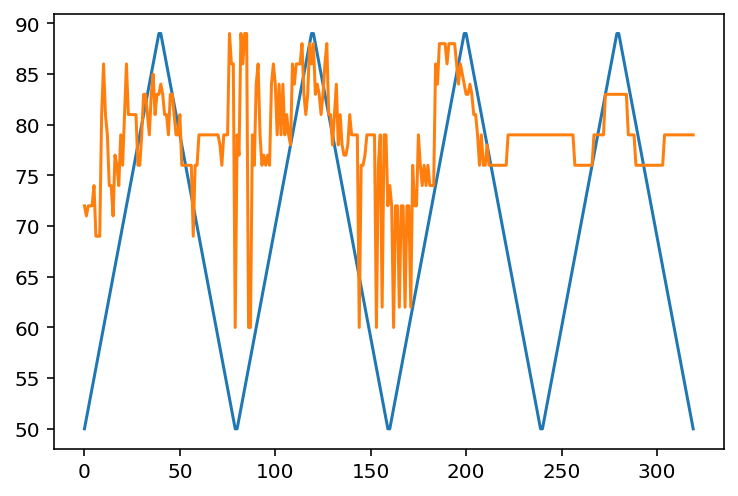

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.plot(list(np.ones(200)*89))

#plt.plot(list(np.ones(200)*50))
#plt.plot(list(np.ones(20)*50))
plt.plot(testing_data_unnorm)
plt.plot(predicted_notes_lst)

In [52]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

Counter({72: 14,
         71: 2,
         74: 10,
         69: 4,
         81: 24,
         86: 17,
         79: 104,
         77: 7,
         76: 62,
         83: 28,
         85: 2,
         84: 13,
         78: 7,
         89: 4,
         60: 6,
         88: 12,
         62: 4})